In [ ]:
# pip installations

!pip install category_encoders==2.*;
!pip install catboost;
!pip install pdpbox;

     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 65.7MB 65kB/s 
     |████████████████████████████████| 57.7MB 80kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp37-none-any.whl size=57690722 sha256=8c5f0d11769af32d3750005c6ab2726e1c576f71f54e2f90969218b5ca817c0a
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [ ]:
#module installations

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, plot_confusion_matrix
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeClassifier, LinearRegression
import lightgbm
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [ ]:
#uploading data

from google.colab import files
uploaded = files.upload()

Saving dnd_monsters.csv to dnd_monsters.csv


#Wrangle

In [ ]:
#wrangle function for the classification methods


# primary wrangle function to set up dataframe for classification modeling
def classifier_wrangle(filepath):
  df = pd.read_csv(filepath,index_col='name')

  # drops high cardinality feature
  df = df.drop(columns=['url'])

  #two lines convert feature to binary boolean
  df['legendary'].fillna(0,inplace=True)
  df['legendary'].replace('Legendary',1,inplace=True)

  # replaces null value with a default value so feature can be properly encoded
  df['speed'].fillna('land',inplace=True)

  # drops observations which are missing the target feature (1 observation)
  df = df.dropna(axis=0, subset=['cr'])
  return df


# a second wrangle function set up to produce dataframes that will be useful for
# regression modeling
def regression_wrangle(filepath):
  df = pd.read_csv(filepath,index_col='name')

  # drops high cardinality feature
  df = df.drop(columns=['url'])

  # converted target variable to floats in order to use regression predictions
  df['cr'].replace(['1/2','1/4','1/8'],[0,0,0],inplace=True)
  df['cr']=df['cr'].astype(float)
  
  #two lines convert feature to binary boolean
  df['legendary'].fillna(0,inplace=True)
  df['legendary'].replace('Legendary',1,inplace=True)
  
  # replaces null value with a default value so feature can be properly encoded
  df['speed'].fillna('land',inplace=True)
  
  # drops observations which are missing the target feature (1 observation)
  df = df.dropna(axis=0, subset=['cr'])
  return df


df = classifier_wrangle('dnd_monsters.csv')
reg = regression_wrangle('dnd_monsters.csv')

#Split

In [ ]:
# splitting feature matrices from target variables for both classification and 
# regression datasets

target = 'cr'
y = df[target]
X = df.drop(columns=target)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

target = 'cr'
y_r = reg[target]
X_r = reg.drop(columns=target)
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r,y_r,test_size=0.2,random_state=42)

#Establish Baseline

In [ ]:
# Baseline accuracy should be same for both regression and classification methods

baseline_acc = df['cr'].value_counts(normalize=True).max()
print(baseline_acc)

0.1116951379763469


#Build Model

In [ ]:
# Random Forest Classifier model

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(),
)

model_rf.fit(X_train,y_train);

In [ ]:
# Gradient Boosting Classifier

model_skgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state=42)
)

model_skgb.fit(X_train,y_train);

In [ ]:
#XGBoost classifier

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42,n_jobs=-1)
)

model_xgb.fit(X_train,y_train);

In [ ]:
# Ridge classifier, used after mistakenly thinking that ridge regression provided
# higher accuracy

model_rc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RidgeClassifier(alpha=100)
)

model_rc.fit(X_train,y_train);

In [ ]:
# Ridge regression model

model_rr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LinearRegression()
)

model_rr.fit(X_r_train,y_r_train);

# Thought this was a regular model score when I first printed it
# After reviewing the documentation I discovered it's acutally MAE

print(model_rr.score(X_r_train,y_r_train))
print(model_rr.score(X_r_test,y_r_test))

0.8781544875858982
0.9055591056907728


In [ ]:
# Random forest regressor model

model_rfr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=74,
                          max_depth = 11,
                          n_jobs=-1,
                          random_state=42)
)

model_rfr.fit(X_r_train,y_r_train);


In [ ]:
# defining variables to translate regression results into classified predictions

y_pred_rr = model_rr.predict(X_r_test).round()
y_pred_rfr = model_rfr.predict(X_r_test).round()
y_obs = y_r_test

#Check Metrics

In [ ]:
# Output of the accuracy of the different models


print(f'Accuracy of Random Forest Classifier Model: {model_rf.score(X_test,y_test)}')
print()
print(f'Accuracy of Gradient Boost Classifier Model: {model_skgb.score(X_test,y_test)}')
print()
print(f'Accuracy of XGBoost Classifier Model: {model_xgb.score(X_test,y_test)}')
print()
print(f'Accuracy of Ridge Classifier Model: {model_rc.score(X_test,y_test)}')
print()
print(f'Accuracy of Random Forest Regressor Model: {accuracy_score(y_pred=y_pred_rfr,y_true=y_obs)}')
print()
print(f'Accuracy of Ridge Regressor Model: {accuracy_score(y_pred=y_pred_rr,y_true=y_obs)}')

Accuracy of Random Forest Classifier Model: 0.33986928104575165

Accuracy of Gradient Boost Classifier Model: 0.28104575163398693

Accuracy of XGBoost Classifier Model: 0.33986928104575165

Accuracy of Ridge Classifier Model: 0.1568627450980392

Accuracy of Random Forest Regressor Model: 0.4117647058823529

Accuracy of Ridge Regressor Model: 0.24183006535947713


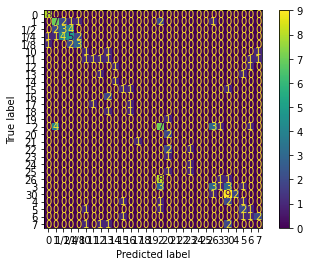

In [ ]:
# I attempted a confusion matrix and only kept it around as an example of what 
# not to do with a confusion matrix

plot_confusion_matrix(
    model_xgb,
    X_test,
    y_test,
    values_format='.0f');

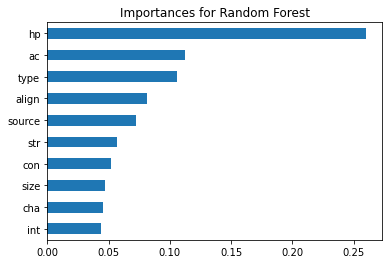

In [ ]:
feature_names = model_rf.named_steps['ordinalencoder'].get_feature_names()
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
feature_importances = pd.Series(importances,index=feature_names).sort_values(key=abs)
feature_importances.tail(10).plot(kind='barh',title='Importances for Random Forest');

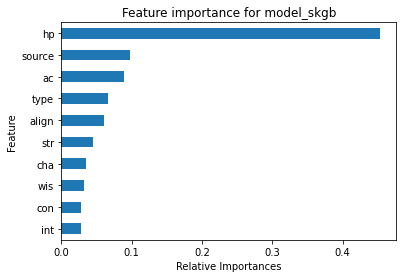

In [ ]:
importances = model_skgb.named_steps['gradientboostingclassifier'].feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Relative Importances')
plt.ylabel('Feature')
plt.title('Feature importance for model_skgb');

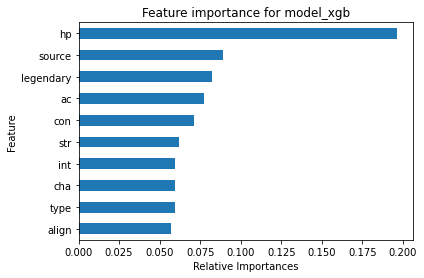

In [ ]:
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Relative Importances')
plt.ylabel('Feature')
plt.title('Feature importance for model_xgb');

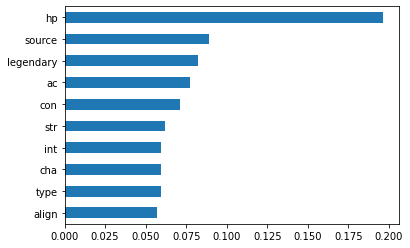

In [ ]:
importances_rfr = model_rfr.named_steps['randomforestregressor'].feature_importances_
feat_imp_rfr = pd.Series(importances_rfr,index=X_r_train.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')

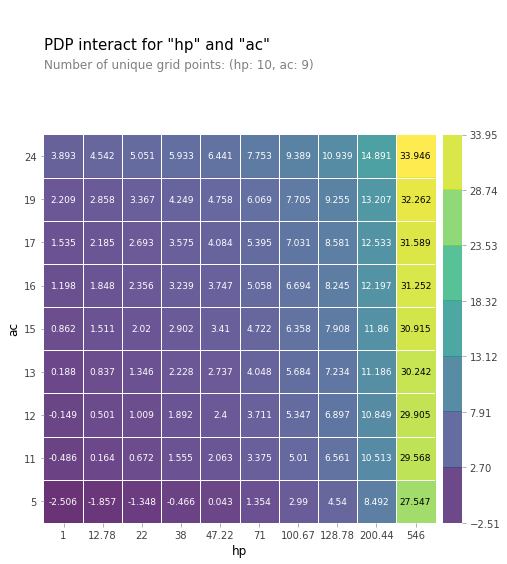

In [ ]:
features = ['hp','ac']

interact = pdp_interact(
    model=model_rr,
    dataset=X_r_test,
    model_features=X_r_test.columns,
    features=features
)

pdp_interact_plot(interact,plot_type='grid',feature_names=features);

#Tune Model

Model tuning was performed on the higher scoring models (RandomForestClassifier and RandomForestRegressor) using several iterations of GridSearchCV. The best identified parameter values were then passed into the models above to minimize active code cells in the notebook.

In [ ]:
# estimator = model_rfr

# params = {
#     'randomforestregressor__n_estimators': [70,75,80],
#     'randomforestregressor__max_depth': range(8,16,1)
# }

# model_tune = GridSearchCV(
#     estimator,
#     param_grid=params,
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# model_tune.fit(X_r_train, y_r_train);

#Communicate Results